### Time Series forecasting for donations to SEF

The organization has a vision to eradicate curable blindness by 2020 in India (http://giftofvision.org/mission-and-vision). That is a bold vision to be able to make such a prediction!

In this notebook, I am attempting to forecast the donations out into the future based on past donations.


In [164]:
from pandas.tslib import Timestamp
import statsmodels.api as sm
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [165]:
def acf_pacf(ts, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)

In [166]:
def get_data_by_month(df):
    df_reindexed = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='1D'), fill_value=0)
    ym_series = pd.Series(df_reindexed.reset_index()['index'].\
          apply(lambda dt: pd.to_datetime(
            dt.to_datetime().year*10000 + dt.to_datetime().month*100 + 1, format='%Y%m%d')))

    df_reindexed['activity_ym'] = ym_series.values
    return df_reindexed.groupby(['activity_ym']).amount.sum().to_frame()

### Time Series analysis

In [196]:
donations = pd.read_pickle('out/21/donations.pkl')

In [220]:
df = donations[donations.is_service==False]\
    .groupby(['activity_date', ])\
    .amount\
    .sum()\
    .to_frame()
df = get_data_by_month(df)

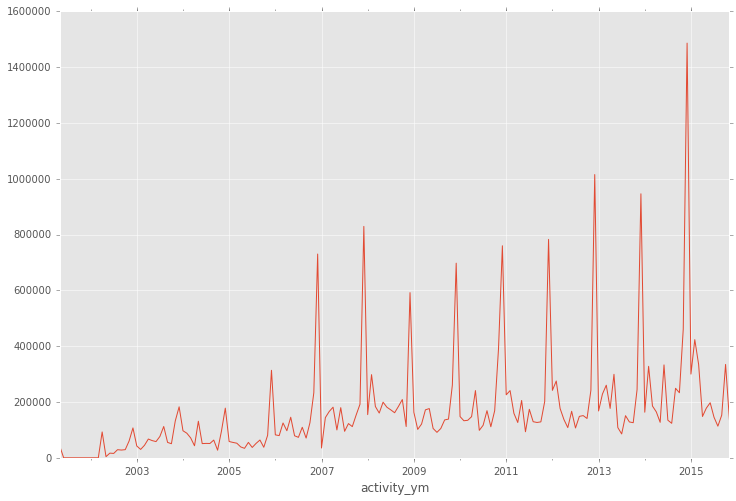

In [221]:
ts = pd.Series(df['amount'])
ts.plot(figsize=(12,8))

### The plot of the data shows that the data was much different before 2003.
#### So let us only consider data from 2003 onwards and plot the data again.
Observations

Original variable (amount) - (ts):
1. The original variable is itself not stationary.
2. The pacf and acf on the original variable cut off at lag of 1.
3. The acf on the original variable indicates seasonality at 12 months.

Differenced variable (ts_diff):
1. The differenced variable has mean 0 but has significant variability that is increasing.

Log transformation on the original variable (log_ts):
1. The log is also not stationary.
2. The acf on log_ts show cut off at lag of 2.
3. The pacf on log_ts show cut off at lag of 1.


Difference on the log transformation on the original variable (log_ts_diff):
1. The difference in the log appears to be stationary with mean 0 and constant variance from the plot of log_ts_diff.

Considering the seasonal portion of log_ts:
1. The acf shows a gradual tailing off.
2. The pacf indicates a cut off at lag of 2.

Based on the above, we want to try out the following seasonal ARIMA models on log of the original variable:

(p=2, d=1, q=1), (P=0, D=1, Q=2, S=12) => model1


In [222]:
df = donations[(donations.activity_year >= 2008) & (donations.is_service==False)]\
    .groupby(['activity_date', ])\
    .amount\
    .sum()\
    .to_frame()
df = get_data_by_month(df)

In [223]:
df.head()

,amount
activity_ym,
2008-01-01,154821
2008-02-01,298058
2008-03-01,183817
2008-04-01,160370
2008-05-01,199355


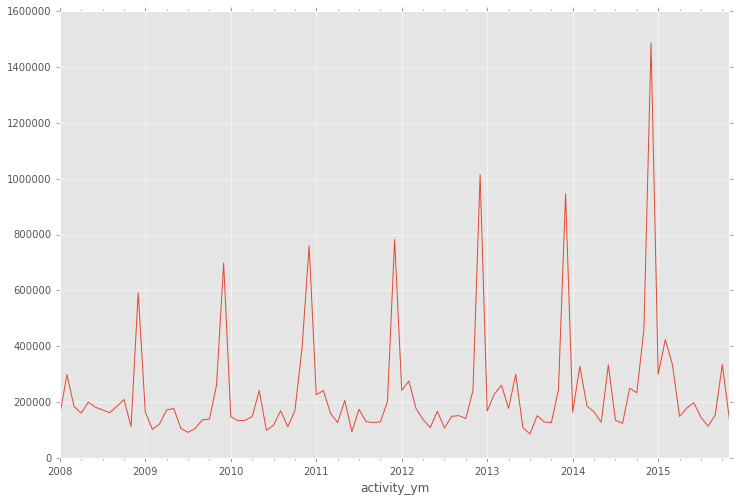

In [224]:
ts = pd.Series(df['amount'])
ts.plot(figsize=(12,8))

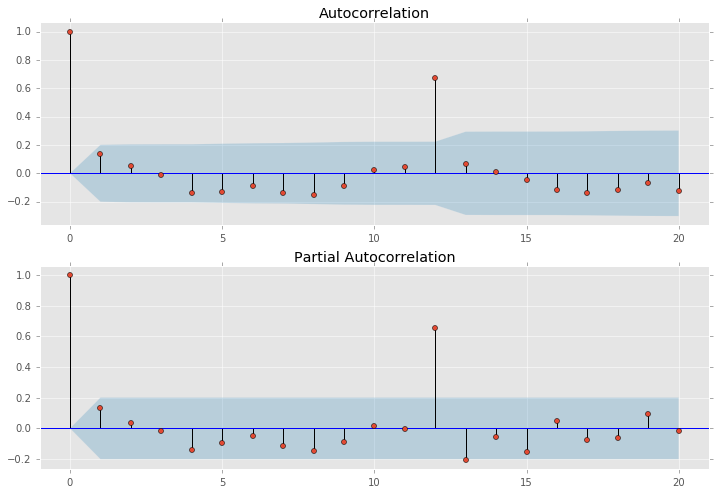

In [225]:
acf_pacf(ts, 20)

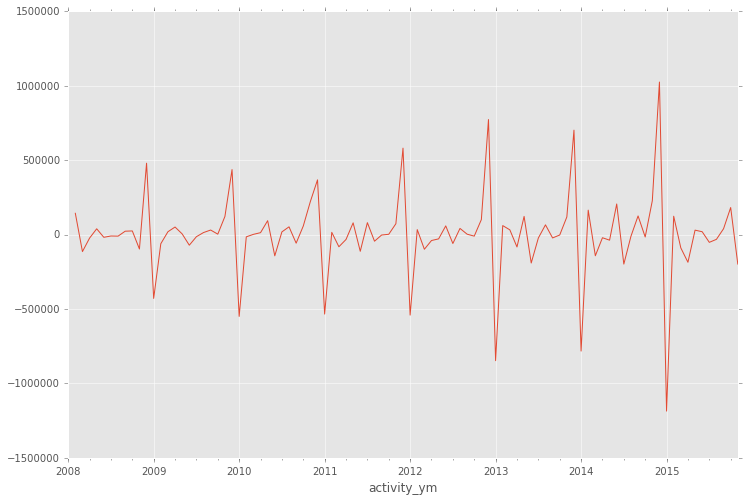

In [226]:
ts_diff = ts.diff(1)
ts_diff.plot(figsize=(12,8))

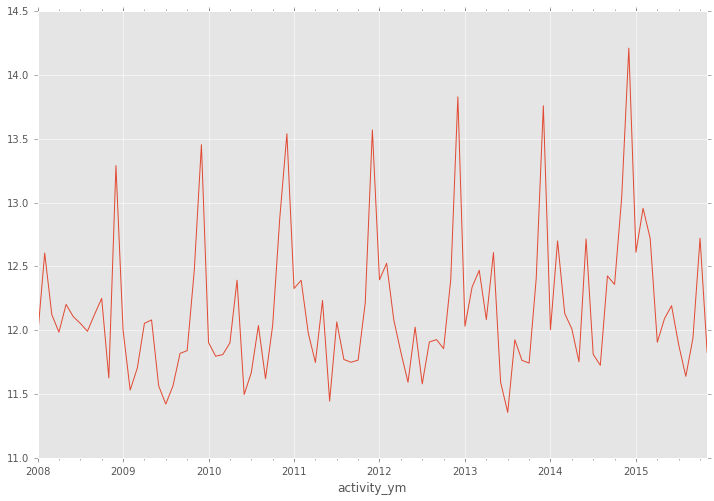

In [227]:
log_ts = np.log(pd.Series(df['amount']))
log_ts.plot(figsize=(12,8))

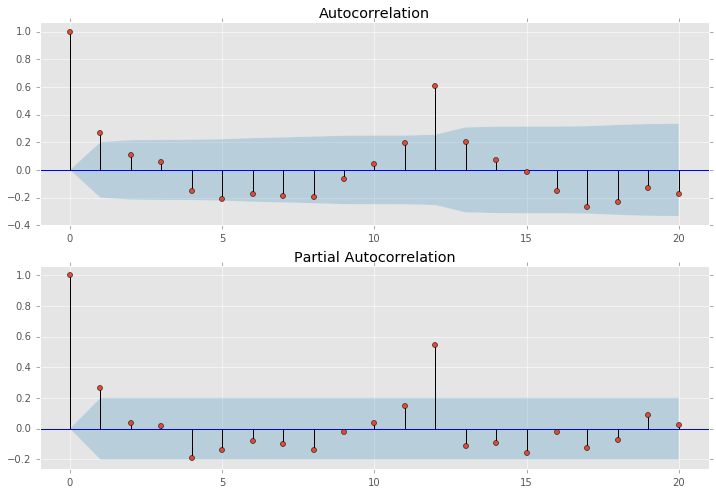

In [228]:
acf_pacf(log_ts, 20)

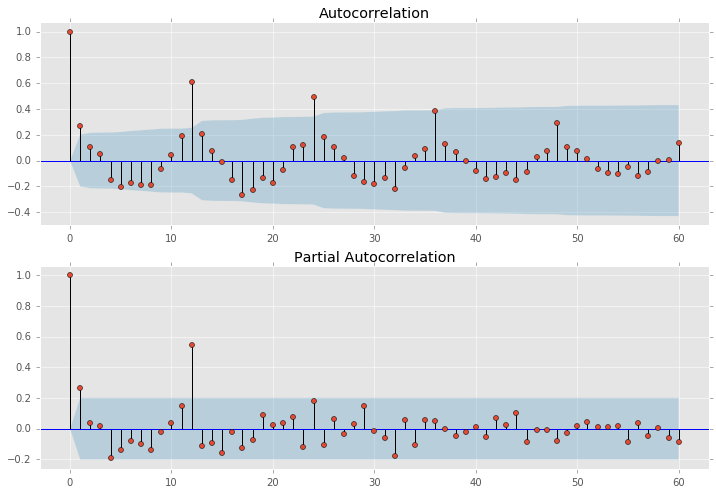

In [229]:
acf_pacf(log_ts, 60)

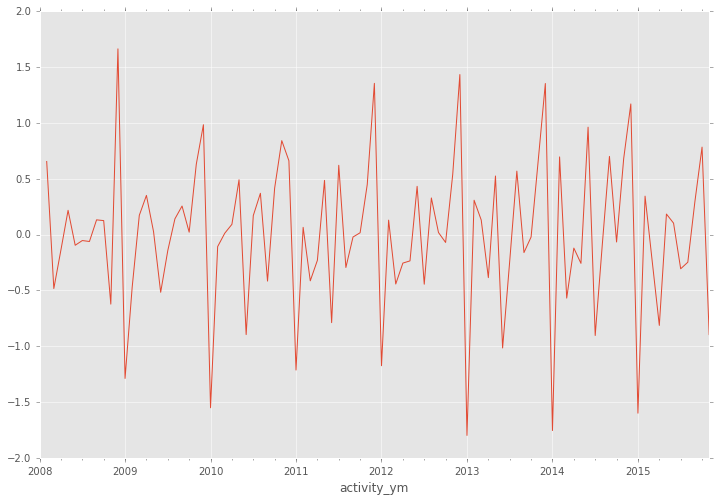

In [230]:
log_ts_diff = log_ts.diff(1)
log_ts_diff.plot(figsize=(12,8))

The above time plot looks great! I see that the residuals have a mean at zero with variability that is constant.
Let us use the log(amount) as the property that we want to model on.

### Modeling

In [231]:
model = sm.tsa.SARIMAX(log_ts, order=(1,1,1), seasonal_order=(0,1,1,12)).fit(enforce_invertibility=False)

In [232]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             amount   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -36.053
Date:                            Tue, 12 Jan 2016   AIC                             80.106
Time:                                    22:10:26   BIC                             90.321
Sample:                                01-01-2008   HQIC                            84.234
                                     - 11-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0650      0.157     -0.413      0.680      -0.373       0.243
ma.L1         -0.7986      0.109     -7.325      0.000      -1.012      -0.585
ma.S.L12      -0.7403      0.226     -3.275      0.001      -1.183      -0.297
sigma2         0.1239      0.026      4.844      0.000       0.074       0.174
===================================================================================
Ljung-Box (Q):                       40.73   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.44   Prob(JB):                         0.45
Heteroskedasticity (H):               1.28   Skew:                             0.10
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients.
"""

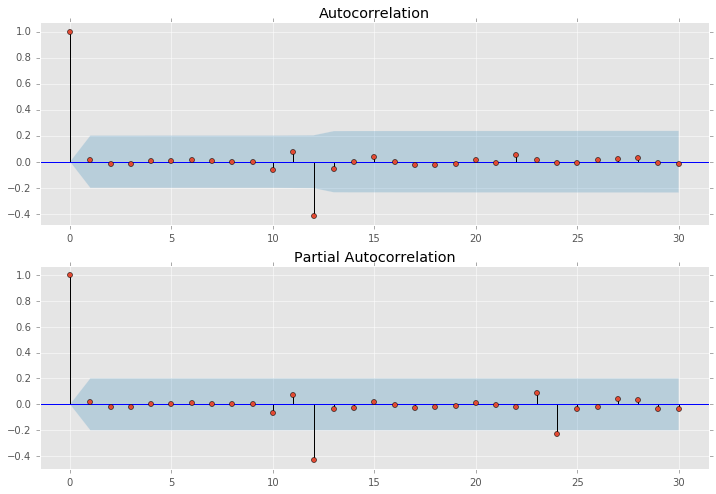

In [233]:
acf_pacf(model.resid, 30)

In [234]:
%%html
<style>table {float:left}</style>

### Model parameters
Note: Even the best model could not git rid of the spike on the residuals (that are happening every 12 months)

Following are the results of various models that I tried.

p|d|q|P|D|Q|S|AIC|BIC|Ljung-Box|Log-likelihood|ar.L1|ar.L2|ma.L1|ma.S.L12|sigma2|
--|--|--|--|--|--|--|----|----|------|----|-------|-------|-------|-------|-------|
0|1|1 |0|1|1|12|101|111|33|-46|0.3771||-0.9237|-0.9952|0.1325| <<-- The best model so far
2|1|1 |0|1|1|12|102|115|35|-46|0.3615|-978|-1.15|-1|0.0991
2|1|0 |0|1|1|12|110|121|46|-51|-0.32|-0.27|-1|-1|0.15
1|1|0 |0|1|1|12|114|122|39|-54|-0.2636|-0.99|0.1638||
0|1|0 |0|1|1|12|118|123|46|-57|-0.99|0.1748|||
0|1|0 |1|1|0|12|136|151|57|-66|-0.58|0.2781|||



In [235]:
ts_predict = ts.append(model.predict(alpha=0.05, start=len(log_ts), end=len(log_ts)+12))

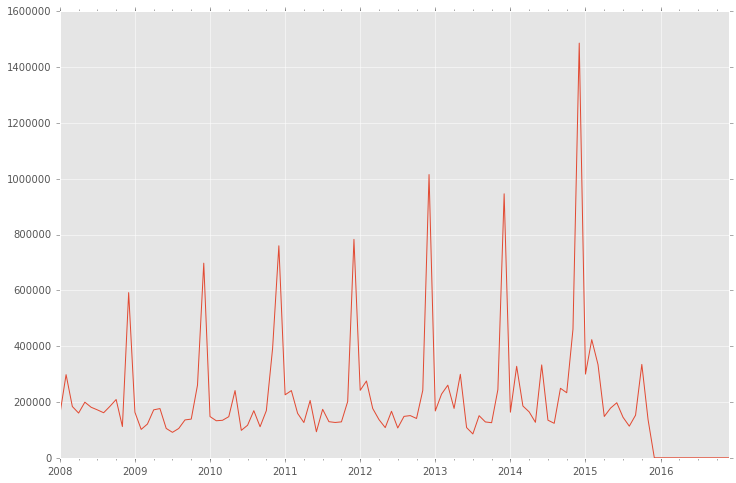

In [236]:
ts_predict.plot(figsize=(12,8))

### Predictions

In [237]:
new_log_ts.shape

(84,)

In [238]:
new_ts = ts[ts.index.year < 2015]
new_log_ts = log_ts[log_ts.index.year < 2015]
new_model = sm.tsa.SARIMAX(new_log_ts, order=(0,1,1), seasonal_order=(0,1,1,12), enforce_invertibility=False).fit()

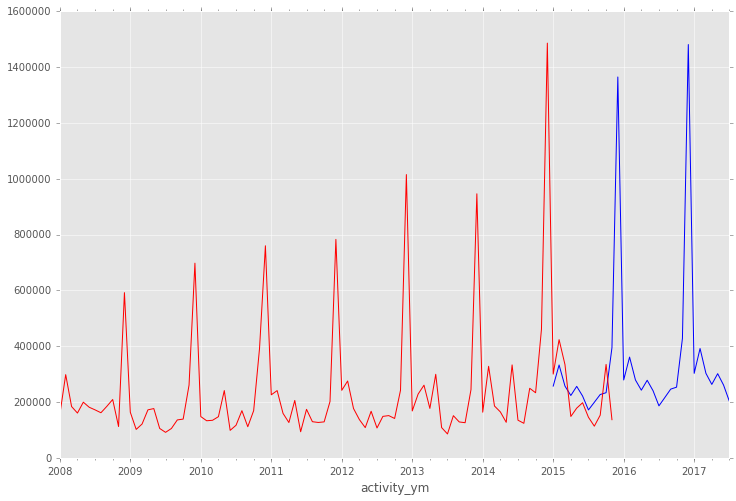

In [239]:
ts_predict = new_ts.append(new_model.predict(start=len(new_log_ts), end=len(new_log_ts)+30).apply(np.exp))
ts_predict[len(new_log_ts):].plot(figsize=(12,8), color='b', label='Predicted')
ts.plot(figsize=(12,8), color='r', label='Actual')


### Make pretty pictures

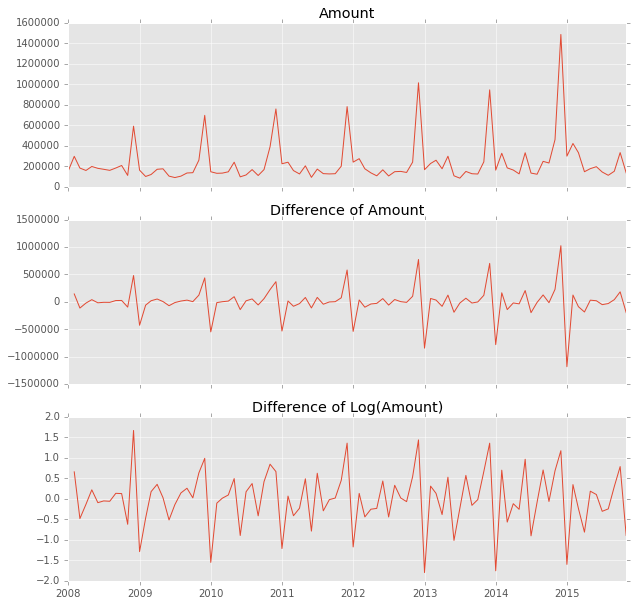

In [240]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,10))
ax1.plot(ts)
ax1.set_title('Amount')
ax2.plot(ts_diff)
ax2.set_title('Difference of Amount')
ax3.plot(log_ts_diff)
ax3.set_title('Difference of Log(Amount)')
plt.savefig('viz/TimeSeriesAnalysis.png')

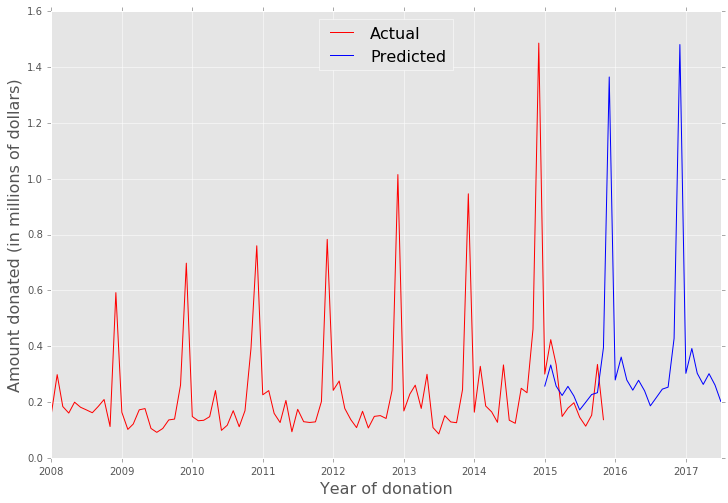

In [241]:
ts_predict = new_ts.append(new_model.predict(start=len(new_log_ts), end=len(new_log_ts)+30).apply(np.exp))
ts_predict_1 = ts_predict/1000000
ts_1 = ts/1000000
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)
plt.ylabel('Amount donated (in millions of dollars)', fontsize=16)
plt.xlabel('Year of donation', fontsize=16)
ax.plot(ts_1, color='r', label='Actual')
ax.plot(ts_predict_1[len(new_log_ts):], color='b', label='Predicted')
plt.legend(prop={'size':16}, loc='upper center')
plt.savefig('viz/TimeSeriesPrediction.png')